In [194]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
import time
import sys, os

In [2]:
def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2)
    else:
        return  np.percentile(np.sort(x),val)

In [221]:
# RSI, %time above RSI
def RSI(series, period=14):
 #print(len(series))
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / pd.stats.moments.ewma(d, com=period-1, adjust=False)
 rs = pd.Series.ewm(u, com=period-1).mean()/pd.Series.ewm(d, com=period-1).mean()
 rsi = 100 - 100 / (1 + rs)
 return np.round(rsi.values[-1],2),np.round(100*np.sum(np.where(rsi>rsi.values[-1],1,0))/len(rsi),2)

In [239]:
def consecutive(x,lag=4):
    c=0
    for i in x[-lag:][::-1]:
        if i>=0:
            c+=1
        else:
            return c
    return c    

def consecutive_increases(x):
    c=0
    latest=x.values[-1]
    for i in x[::-1]:
        if i==latest:
            continue
        if latest>i:
            c+=1
            latest=i
        else:
            return c
    return c    
        

In [241]:
# Consecutive increases, hist percentile, hist change mean 4 week, slope of 4 week macd
def macd_calcs(x):
    macd=x.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-x.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
    signal=macd.ewm(span=9,min_periods=0,adjust=True,ignore_na=True).mean()
    macd_hist=macd-signal
    return consecutive_increases(macd_hist), get_percentile(macd_hist),(macd_hist/macd_hist.shift(1)-1).rolling(4).mean().values[-1:][0],np.polyfit(x=[1,2,3,4],y=macd.values[-4:],deg=1,full=False)[0]

In [180]:
def get_intraday(ticker):
    url='https://cloud.iexapis.com/stable/stock/{}/intraday-prices?token=pk_9469e57bc642462d905e4dc0003523ab&chartLast=10&chartIEXWhenNull=True&chartInterval=10'
    d={'chartIEXOnly': False}
    response = requests.get(
        url.format(ticker),
       params=d
        )
    for i in response.json()[::-1]:
        if ((i['close'] is None)==False):
            return ([i['open'],i['high'],i['low'],i['close'],i['close']])
    url='https://cloud.iexapis.com/stable/stock/{}/intraday-prices?token=pk_9469e57bc642462d905e4dc0003523ab&chartLast=10&chartIEXWhenNull=True&chartInterval=10'
    d={'chartIEXOnly': True}
    response = requests.get(
        url.format(ticker),
       params=d
        )
    for i in response.json()[::-1]:
        if ((i['marketClose'] is None)==False):
            return([i['marketOpen'],i['marketHigh'],i['marketLow'],i['marketClose'],i['marketClose']])

In [3]:
#holdings=['RHHBY','BIG','DOCU','CLX']RH, ARKF, JHG
holdings=['CDNS']

In [13]:
holdings='SPY,MSFT,SVMK,CHWY,EA,OLLI,SHOP,NEWR,DKS,MBUU,ADBE,CLDR,QQQ,TSLA,ESTC,CLX,CDNS,MELI,NYT,CWH,DKNG,ARKF,BAK,JHG,THO,TTD,FTNT,WK,NET,SNAP,DDOG,W'



In [14]:
holdings=holdings.split(',')

In [229]:
holdings=['SPY','W','CWH']


In [230]:
#ticker, #1wkret #1wkmean, 4wk, 4wkmean,k, kchange1, kchange4,k_change percentile,
#rsi, rsitimeabove, macdslope,histchange_mean,histcons,hist_perc
res=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

In [231]:
c=1
for ticker in holdings:
    #print(ticker)
    c+=1
    if c==5:
        c=1
        time.sleep(60)
    d={'function': 'TIME_SERIES_WEEKLY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'outputsize':'full'}
    response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )
    print(ticker)#,response.json())
    try:
        spy=[[],[],[],[],[],[],[]]
        for key, val in response.json()['Weekly Adjusted Time Series'].items():
            spy[0].append(float(val['1. open']))
            spy[1].append(float(val['2. high']))
            spy[2].append(float(val['3. low']))
            spy[3].append(float(val['4. close']))
            spy[4].append(float(val['5. adjusted close']))
            #spy[5].append(float(val['6. volume']))
            #spy[6].append(float(val['7. dividend amount']))
        t=list(response.json()['Weekly Adjusted Time Series'].keys())
        time.sleep(1)
        '''
        try:
            if (pd.to_datetime(t[0]).date()==pd.Timestamp.today().date())==False:
                x=get_intraday(ticker)
                spy[0].insert(0,float(x[0]))
                spy[1].insert(0,float(x[1]))
                spy[2].insert(0,float(x[2]))
                spy[3].insert(0,float(x[3]))
                spy[4].insert(0,float(x[4]))
                t.insert(0,str(pd.Timestamp.today().date()))

                #spy[0].append(float(t.insert(0,response2.json()[0]['date'])))
        except:
            print(ticker,'IEX')
        '''


        spy=pd.DataFrame({'Date':t,
                     'open':spy[0],
                      'high':spy[1],
                      'low':spy[2],
                      'close':spy[3],
                      'adj_close':spy[4]#,
                    #  'volume':spy[5],
                    #  'dividend':spy[6],
                     })
        spy=spy.astype({'Date': 'datetime64'})
        spy=spy.sort_values(by='Date')   
        spy['ret4wk']=spy.adj_close/spy.adj_close.shift(3)-1
        spy['highest_high']=spy.high.rolling(12).max()
        spy['lowest_low']=spy.low.rolling(12).min()
        spy['k']=(spy.close-spy.lowest_low)/(spy.highest_high-spy.lowest_low)
        spy['k']=spy.k.rolling(3).mean()
        spy['k_change1'] = spy.k/spy.k.shift(1)-1
        spy['k_change4'] = spy.k/spy.k.shift(3)-1        
        spy['ret1wk']=spy.adj_close/spy.adj_close.shift(1)-1
        
        #d={'ticker':ticker,'k_change':spy.k_change.values[-1]}
        res[0].append(ticker)
        res[1].append(spy.ret1wk.values[-1])
        res[2].append(spy.ret1wk.rolling(3).mean().values[-1])
        res[3].append(spy.ret4wk.values[-1])
        res[4].append(spy.ret4wk.rolling(3).mean().values[-1])
        res[5].append(spy.k.values[-1])
        res[6].append(spy.k_change1.values[-1])
        res[7].append(spy.k_change4.values[-1])
        res[8].append(get_percentile(spy.k_change1))
        res[9].append(spy.iloc[-1]['Date'])
        temp_res=RSI(spy.adj_close)
        res[10].append(temp_res[0])
        res[11].append(temp_res[1])
        temp_res=macd_calcs(spy.adj_close)
        res[12].append(temp_res[3])
        res[13].append(temp_res[2])
        res[14].append(temp_res[0])
        res[15].append(temp_res[1])
        
    except:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(ticker,exc_type, exc_tb.tb_lineno) 



    
    
    

SPY
W
CWH


In [232]:
cols=[
'ticker', 
'ret1wk',
'ret1wk_mean',
'ret4wk',
'ret4wk_mean',
'k',
'k_change1',     
'k_change4',
'k_change_percentile',
'Date'
,'RSI'
,'RSITime_above',
'macdslope',
'histchange_mean',
'histcons',
'hist_perc'
]


In [233]:
np.round(pd.DataFrame(zip(*res), columns=cols),4)

,ticker,ret1wk,ret1wk_mean,ret4wk,ret4wk_mean,k,k_change1,k_change4,k_change_percentile,Date,RSI,RSITime_above,macdslope,histchange_mean,histcons,hist_perc
0,SPY,0.0191,0.0070,0.0187,0.0546,0.8710,-0.0568,0.1030,30.22,2020-06-19,55.27,56.56,1.4739,0.5485,1,99.90
1,W,0.1366,0.0713,0.2241,0.1086,0.9219,0.0506,0.0893,60.56,2020-06-19,73.69,8.80,2.7739,-0.0272,1,98.66
2,CWH,0.1562,0.0880,0.2841,0.2850,0.8988,0.0360,-0.0293,58.66,2020-06-19,76.77,3.91,0.6164,0.1887,3,99.48


In [ ]:
'''
res=pd.DataFrame({'ticker':res[0], 
            'ret1wk':res[1],
             'ret1wk_mean':res[2],
             'ret4wk':res[3],
             'ret4wk_mean':res[4],
             'k':res[5],
             'k_change':res[6],     
             'k_change_mean':res[7],
             'k_change_percentile':res[8],
             'rstd':res[9],
             'rstd_mean':res[10]
             }
            )
'''

In [18]:
# Amount of time above current K
res.sort_values(by='ret1wk_mean',ascending=False)

,ticker,ret1wk,ret1wk_mean,ret4wk,ret4wk_mean,k,k_change,k_change_mean,k_change_percentile,rstd,rstd_mean
24,THO,0.060459,0.096350,0.314501,0.338840,0.925859,-0.006969,0.011032,47.52,23.869725,22.240688
19,CWH,0.156183,0.088002,0.284092,0.284972,0.898792,0.036019,-0.009355,58.66,7.695676,7.087401
25,TTD,0.113593,0.083788,0.267107,0.200179,0.947479,0.012826,0.021022,54.14,66.349922,63.778784
11,CLDR,0.104310,0.080911,0.249756,0.208962,0.782449,-0.062746,-0.035833,32.00,1.691545,1.337303
28,NET,0.249133,0.080186,0.238390,0.082113,0.859389,-0.013259,-0.008998,42.31,4.042018,3.430110
31,W,0.136556,0.071312,0.224075,0.108550,0.921914,0.050598,0.029220,60.56,50.282320,53.523000
30,DDOG,0.111980,0.069335,0.217763,0.112823,0.935103,0.011429,0.002769,44.00,18.201686,17.038259
29,SNAP,0.122894,0.062968,0.196410,0.175782,0.963970,0.001156,0.012280,50.63,3.340554,3.264036
13,TSLA,0.070161,0.062286,0.198683,0.150616,0.921204,0.007770,0.008646,53.36,145.541286,148.865479
6,SHOP,0.186404,0.055709,0.162576,0.003780,0.853070,0.055280,-0.030121,71.31,155.874911,160.858576


In [19]:
res.sort_values(by='ret1wk',ascending=False)

,ticker,ret1wk,ret1wk_mean,ret4wk,ret4wk_mean,k,k_change,k_change_mean,k_change_percentile,rstd,rstd_mean
28,NET,0.249133,0.080186,0.238390,0.082113,0.859389,-0.013259,-0.008998,42.31,4.042018,3.430110
6,SHOP,0.186404,0.055709,0.162576,0.003780,0.853070,0.055280,-0.030121,71.31,155.874911,160.858576
19,CWH,0.156183,0.088002,0.284092,0.284972,0.898792,0.036019,-0.009355,58.66,7.695676,7.087401
20,DKNG,0.138829,0.022410,0.057935,0.223577,0.840721,-0.029877,-0.040887,48.48,10.611001,10.268690
31,W,0.136556,0.071312,0.224075,0.108550,0.921914,0.050598,0.029220,60.56,50.282320,53.523000
29,SNAP,0.122894,0.062968,0.196410,0.175782,0.963970,0.001156,0.012280,50.63,3.340554,3.264036
27,WK,0.122247,0.047659,0.143916,0.094923,0.930241,-0.001329,0.014907,45.62,6.017276,5.390046
5,OLLI,0.119040,0.039678,0.116348,0.162684,0.935408,0.004137,-0.012271,48.15,18.395027,18.467176
25,TTD,0.113593,0.083788,0.267107,0.200179,0.947479,0.012826,0.021022,54.14,66.349922,63.778784
30,DDOG,0.111980,0.069335,0.217763,0.112823,0.935103,0.011429,0.002769,44.00,18.201686,17.038259


In [21]:
res.sort_values(by='k_change_percentile',ascending=False)

,ticker,ret1wk,ret1wk_mean,ret4wk,ret4wk_mean,k,k_change,k_change_mean,k_change_percentile,rstd,rstd_mean
6,SHOP,0.186404,0.055709,0.162576,0.003780,0.853070,0.055280,-0.030121,71.31,155.874911,160.858576
15,CLX,0.061037,0.019056,0.055224,0.009893,0.847166,0.042399,0.006480,60.84,11.573554,11.972681
31,W,0.136556,0.071312,0.224075,0.108550,0.921914,0.050598,0.029220,60.56,50.282320,53.523000
19,CWH,0.156183,0.088002,0.284092,0.284972,0.898792,0.036019,-0.009355,58.66,7.695676,7.087401
25,TTD,0.113593,0.083788,0.267107,0.200179,0.947479,0.012826,0.021022,54.14,66.349922,63.778784
10,ADBE,0.052812,0.034608,0.107113,0.079301,0.975331,0.008713,0.004686,54.03,38.040405,36.477371
13,TSLA,0.070161,0.062286,0.198683,0.150616,0.921204,0.007770,0.008646,53.36,145.541286,148.865479
8,DKS,0.007675,0.032971,0.101291,0.237544,0.939707,0.007404,0.106335,52.97,6.407439,6.341823
29,SNAP,0.122894,0.062968,0.196410,0.175782,0.963970,0.001156,0.012280,50.63,3.340554,3.264036
17,MELI,0.063061,0.038336,0.118931,0.100998,0.980106,0.000385,0.006186,49.32,165.459999,164.163370


In [107]:
res.sort_values(by='ret1wk',ascending=False)

,ticker,ret1wk,ret1wk_mean,ret4wk,ret4wk_mean,k,k_change,k_change_mean,k_change_percentile,rstd,rstd_mean
24,THO,0.099500,0.103861,0.341835,0.286541,0.944832,0.123318,0.342866,62.16,22.708754,20.215007
15,CWH,0.084125,0.062521,0.199100,0.368677,0.876476,-0.020463,0.386562,47.16,7.076473,6.527578
1,TW,0.055654,0.018165,0.051017,0.069907,0.897245,-0.081736,0.004795,32.61,8.109543,8.474604
5,BL,0.044267,0.040918,0.126906,0.151780,0.939289,0.033385,0.244588,52.60,9.335367,8.908239
3,ADBE,0.035429,0.018401,0.055962,0.061154,0.972220,0.051440,0.184770,58.46,35.881308,34.564291
6,QQQ,0.027244,0.023493,0.072107,0.061150,0.989736,0.094457,0.218314,63.81,19.825210,20.672838
13,MELI,0.022897,0.017710,0.054047,0.086063,0.978401,0.019630,0.234729,53.06,163.119925,158.773491
12,CDNS,0.019584,0.027228,0.082975,0.101247,0.974597,0.016699,0.042023,52.63,10.178704,10.971282
19,ARKF,0.018868,0.031241,0.096447,0.100618,0.986318,0.048118,0.222499,57.41,3.676641,3.613368
8,CLF,0.016975,0.124580,0.408120,0.357198,0.905972,0.989104,1.054941,85.89,1.009060,0.836185


In [9]:
msft=spy.copy(deep=True)

In [14]:
msft['ret4wk']=msft.adj_close/msft.adj_close.shift(3)-1
spy['ret4wk']=spy.adj_close/spy.adj_close.shift(3)-1

In [16]:
spy['highest_high']=spy.high.rolling(12).max()
spy['lowest_low']=spy.low.rolling(12).min()
spy['k']=(spy.close-spy.lowest_low)/(spy.highest_high-spy.lowest_low)
spy['k']=spy.k.rolling(3).mean()
spy['k_change'] = spy.k/spy.k.shift(3)-1

msft['highest_high']=msft.high.rolling(12).max()
msft['lowest_low']=msft.low.rolling(12).min()
msft['k']=(msft.close-msft.lowest_low)/(msft.highest_high-msft.lowest_low)
msft['k']=msft.k.rolling(3).mean()
msft['k_change'] = msft.k/msft.k.shift(3)-1




In [22]:
spy['rstd']=spy.adj_close.rolling(12).std()
msft['rstd']=msft.adj_close.rolling(12).std()

In [25]:
msft['ret1wk']=msft.adj_close/msft.adj_close.shift(1)-1
spy['ret1wk']=spy.adj_close/spy.adj_close.shift(1)-1

In [26]:
msft.tail(10)

,Date,open,high,low,close,adj_close,volume,dividend,ret4wk,highest_high,lowest_low,k,k_change,rstd,ret1wk
9,2020-03-20,140.00,150.15,135.0000,137.35,137.35,421347734.0,0.0,-0.152213,190.70,135.00,0.226001,-0.641828,12.881111,-0.135239
8,2020-03-27,137.01,156.66,132.5200,149.70,149.70,358866845.0,0.0,-0.073467,190.70,132.52,0.242002,-0.424578,13.538858,0.089916
7,2020-04-03,152.44,164.78,150.0100,153.83,153.83,290191457.0,0.0,-0.031480,190.70,132.52,0.234586,-0.239293,13.876028,0.027589
6,2020-04-09,160.32,170.00,157.5800,165.14,165.14,229630744.0,0.0,0.202330,190.70,132.52,0.407414,0.802706,13.859286,0.073523
5,2020-04-17,164.35,180.00,162.3000,178.60,178.60,238965670.0,0.0,0.193053,190.70,132.52,0.572992,1.367711,14.477445,0.081507
4,2020-04-24,176.63,178.75,166.1102,174.55,174.55,194621072.0,0.0,0.134694,190.70,132.52,0.691704,1.948616,14.676007,-0.022676
3,2020-05-01,176.59,180.40,169.3900,174.57,174.57,212119968.0,0.0,0.057103,190.70,132.52,0.745732,0.830404,13.910374,0.000115
2,2020-05-08,174.49,185.00,173.8000,184.68,184.68,158579959.0,0.0,0.034043,188.18,132.52,0.794096,0.385877,13.888795,0.057914
1,2020-05-15,183.15,187.51,175.6800,183.16,183.16,196126640.0,0.0,0.049327,187.51,132.52,0.860257,0.243678,14.351698,-0.008230
0,2020-05-19,185.75,186.60,183.4900,183.63,183.63,61664938.0,0.0,0.051899,187.51,132.52,0.929152,0.245960,15.227043,0.002566


In [38]:
spy.ret4wk.rolling(3).mean().values[-1]
spy.k_change.rolling(3).mean().values[-1]
spy.rstd.rolling(3).mean().values[-1]

22.84021899844733

In [47]:
spy.ret1wk.values[-1]

0.019875646220483656

In [37]:
get_percentile(w.ret1wk.dropna(),t='val',val=90)

0.09707991655282944

In [50]:
np.nanpercentile(w.ret1wk, 10)

-0.08731465378421903

In [89]:
# Positive weeks, very good weeks, very bad weeks
def needs(x,weeks=4):

    return np.sum(np.where(x[-weeks:]>0,1,0)),np.sum(np.where(x[-weeks:]>np.nanpercentile(x, 90),1,0)),np.sum(np.where(x[-weeks:]<np.nanpercentile(x, 10),1,0))

In [92]:
needs(spy.ret1wk, weeks=12)

(7, 6, 1)

In [93]:
needs(w.ret1wk, weeks=12)

(9, 5, 0)

In [58]:
# Very Negative weeks last month
np.sum(np.where(spy.ret1wk[-4:]<np.nanpercentile(spy.ret1wk, 10),1,0))

1

In [59]:
np.nanpercentile(spy.ret1wk, 10)

-0.02439089484482181

In [101]:
consecutive(w.ret1wk)

2

In [235]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
signal=macd.ewm(span=9,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [171]:
macd_calcs(w.adj_close)

(1, 98.66, -0.027194908721826033, 2.7739223004763023)

In [236]:
macd_calcs(spy.adj_close)

(3, 99.48, 0.18872043918103842, 0.6163966218831586)

In [122]:
get_percentile(macd_hist)

99.9

In [240]:
consecutive_increases(macd_hist)

11

In [238]:
macd_hist

192    0.000000
191    0.007509
190    0.014215
189    0.006945
188    0.052956
         ...   
4      0.972304
3      1.330281
2      1.544915
1      1.685569
0      1.911974
Name: adj_close, Length: 193, dtype: float64

In [163]:
(macd/macd.shift(4)-1)#.rolling(4).mean().tail(20)#.values#[-1:][0]

1042         NaN
1041         NaN
1040         NaN
1039         NaN
1038        -inf
          ...   
4      -0.450351
3      -0.625619
2      -0.936080
1      -1.069276
0      -1.321178
Name: adj_close, Length: 1043, dtype: float64

In [154]:
get_percentile(macd)

48.03

In [242]:
np.polyfit(x=[1,2,3,4],y=macd.values[-4:],deg=1,full=False)[0]

0.6163966218831586

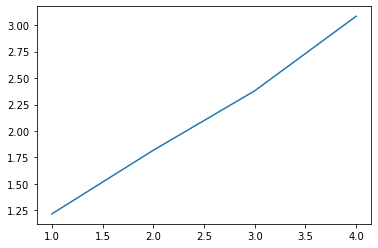

In [243]:
plt.plot([1,2,3,4],macd[-4:])

In [234]:
spy

,Date,open,high,low,close,adj_close,ret4wk,highest_high,lowest_low,k,k_change1,k_change4,ret1wk
192,2016-10-14,22.61,22.9900,20.83,21.06,18.4395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,2016-10-21,21.03,22.1800,20.45,21.92,19.1925,NaN,NaN,NaN,NaN,NaN,NaN,0.040836
190,2016-10-28,22.15,23.0300,22.00,22.36,19.5777,NaN,NaN,NaN,NaN,NaN,NaN,0.020070
189,2016-11-04,22.46,22.6799,21.41,22.03,19.2888,0.046059,NaN,NaN,NaN,NaN,NaN,-0.014757
188,2016-11-11,22.15,24.3800,20.51,24.07,21.0750,0.098085,NaN,NaN,NaN,NaN,NaN,0.092603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-05-22,17.00,20.9600,16.91,19.99,19.8598,1.428917,20.96,3.4,0.894786,0.280993,1.724512,0.260404
3,2020-05-29,21.66,23.7300,20.05,21.18,21.0421,0.512862,23.73,3.4,0.925931,0.034807,0.898018,0.059532
2,2020-06-05,21.66,24.9700,21.15,22.11,21.9660,0.394074,24.97,3.4,0.895580,-0.032779,0.282129,0.043907
1,2020-06-12,23.21,26.4900,20.57,23.37,23.3700,0.176749,26.49,4.1,0.867543,-0.031305,-0.030446,0.063917
